<a href="https://colab.research.google.com/github/bielalpha/Tensorflow_study/blob/master/Image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Sep 22 15:01:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras
from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = (224, 224,3)
train_test_dir = os.path.join('/content/drive/MyDrive/', 'Disiase')
train_ds = tf.keras.utils.image_dataset_from_directory(train_test_dir,
                                                            shuffle=True,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=1,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 709 files belonging to 3 classes.
Using 568 files for training.


In [4]:
test_ds = tf.keras.utils.image_dataset_from_directory(train_test_dir,
                                                            shuffle=True,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            seed=1,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 709 files belonging to 3 classes.
Using 141 files for validation.


In [5]:
train_class = train_ds.class_names
train_class

['acne', 'dermatite', 'vitiligo']

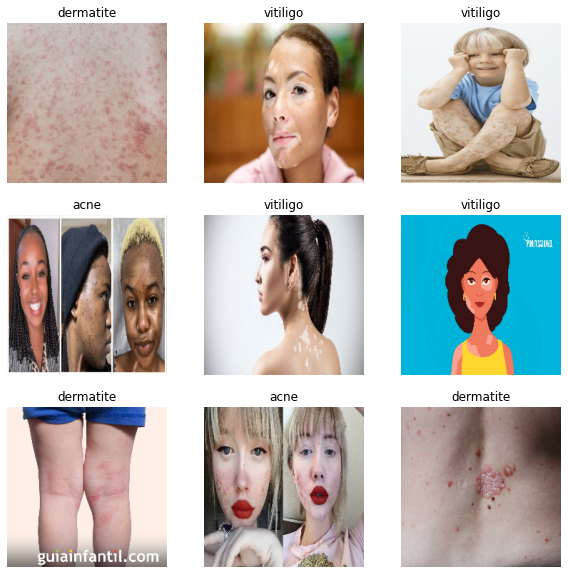

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_class[labels[i]])
    plt.axis("off")

In [7]:
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2)
])

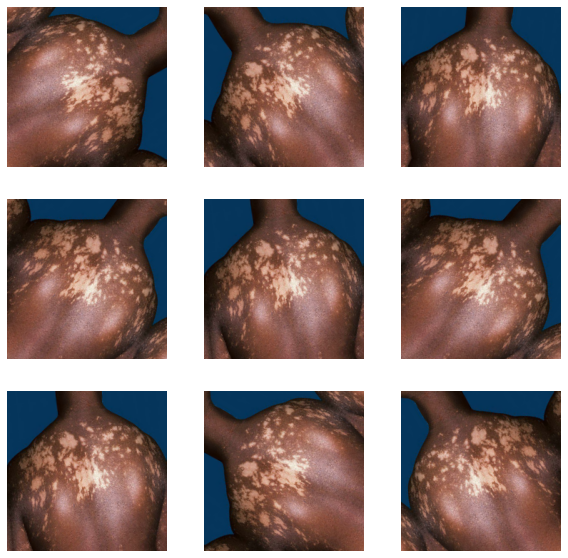

In [8]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(expand_dims(first_image,0))
    plt.imshow(augmented_image[0]/255)
    plt.axis("off")

In [9]:
from tensorflow.keras.applications import EfficientNetB2

base_model = EfficientNetB2(include_top=False,weights='imagenet',input_shape=IMG_SHAPE)

31801344/31790344 [==============================] - 0s 0us/step


In [10]:
image_batch,label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1408)


In [11]:
from tensorflow.keras.layers import GlobalAveragePooling2D
print(GlobalAveragePooling2D() (feature_batch).shape)

(32, 1408)


In [12]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout,Dense
from tensorflow.keras import Model

In [13]:
inputs = Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(270, activation='softmax')(x)
model = Model(inputs,outputs)

In [14]:
from keras.callbacks import ModelCheckpoint,EarlyStopping


In [15]:
file_path = 'my_best_model.hdf5'

earlyStopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=10,
    verbose=2,
    mode='auto'
)

checkpoint = ModelCheckpoint(
    file_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=2,
    mode='max',
    save_weights_only=False
)

callbacks = [earlyStopping,checkpoint]

In [16]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss = SparseCategoricalCrossentropy(from_logits = True),
              optimizer = opt,
              metrics = ['accuracy'])

In [17]:
file_paths = train_ds.file_paths
file_split = []
for x in file_paths:
  data_split = str(x).split('/')
  file_split.append(data_split[-1])

In [18]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_class), y= train_class)
#model.fit(X_train, y_train, class_weight=class_weights)

In [19]:
hist = model.fit(
    train_ds,
    epochs = 10,
    validation_data = test_ds,
    verbose = 1,
    callbacks = callbacks)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


18/18 [==============================] - ETA: 0s - loss: 2.9788 - accuracy: 0.3944
Epoch 1: val_accuracy improved from -inf to 0.69504, saving model to my_best_model.hdf5
18/18 [==============================] - 57s 2s/step - loss: 2.9788 - accuracy: 0.3944 - val_loss: 0.7238 - val_accuracy: 0.6950
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.7741 - accuracy: 0.6567
Epoch 2: val_accuracy improved from 0.69504 to 0.73759, saving model to my_best_model.hdf5
18/18 [==============================] - 11s 588ms/step - loss: 0.7741 - accuracy: 0.6567 - val_loss: 0.6209 - val_accuracy: 0.7376
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.4506 - accuracy: 0.8204
Epoch 3: val_accuracy improved from 0.73759 to 0.81560, saving model to my_best_model.hdf5
18/18 [==============================] - 12s 606ms/step - loss: 0.4506 - accuracy: 0.8204 - val_loss: 0.5084 - val_accuracy: 0.8156
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss

In [20]:
new_model = tf.keras.models.load_model('/content/my_best_model.hdf5')

In [21]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 global_average_pooling2d_1   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 270)               380430    
                                                             

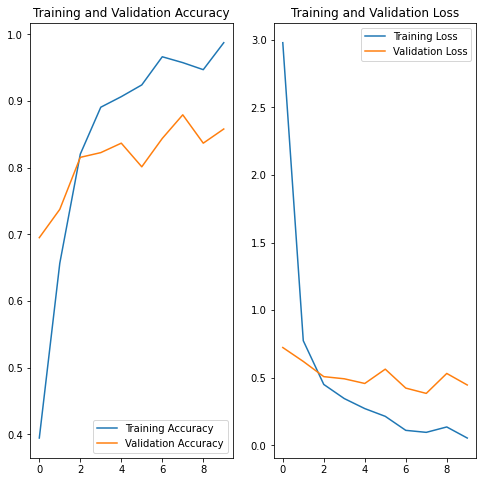

In [22]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
disiase_url = "https://images.saymedia-content.com/.image/t_share/MTczOTY0OTAzNjkyOTAzNzMx/backne.jpg"
disiase_path = tf.keras.utils.get_file('acne_998', origin=disiase_url)

img = tf.keras.utils.load_img(
    disiase_path, target_size=IMG_SIZE
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(train_class[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to acne with a 0.66 percent confidence.


In [28]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = model.predict(test_ds)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)
confusion_matrix(predicted_categories, true_categories)

array([[12, 11, 17],
       [13, 18, 17],
       [14, 17, 22]])

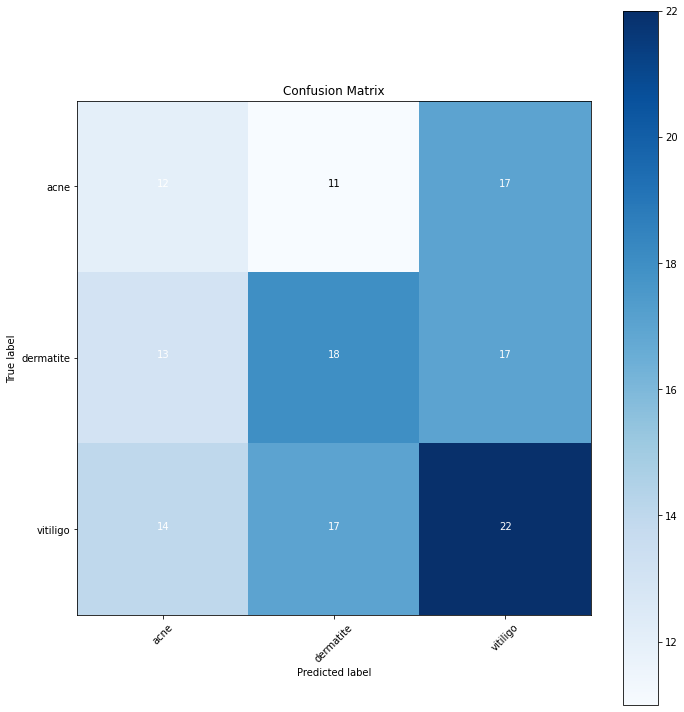

In [40]:
import numpy as np
target_names = ['acne', 'dermatite', 'vitiligo']
cm = confusion_matrix(predicted_categories, true_categories)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

In [39]:
from sklearn.metrics import classification_report
target_names = ['acne', 'dermatite', 'vitiligo']
print(classification_report(true_categories, predicted_categories, target_names=target_names))

              precision    recall  f1-score   support

        acne       0.30      0.31      0.30        39
   dermatite       0.38      0.39      0.38        46
    vitiligo       0.42      0.39      0.40        56

    accuracy                           0.37       141
   macro avg       0.36      0.36      0.36       141
weighted avg       0.37      0.37      0.37       141

